# Import all the libraries here

In [1]:
# settings
import time
import os
import shutil
import random

# basic
import numpy as np

# plot
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# torchvision
from torchvision.utils import make_grid
from torchvision import models, transforms

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## Dataset loader

In [2]:
# Define the custom dataset for .pt files
class PTImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(folder))

        for label_idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(folder, class_name)
            for file in os.listdir(class_folder):
                if file.endswith(".pt"):
                    self.data.append(os.path.join(class_folder, file))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.load(self.data[idx])
        label = self.labels[idx]

        # Normalize if not in [-1, 1]
        if image.min() < -1.0 or image.max() > 1.0:
            image = (image - 0.5) / 0.5

        if self.transform:
            image = self.transform(image)
        return image, label

## Plant seed for reproduction

In [3]:
# Set seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data path

In [4]:
# Paths
data_path = "../data/cv_images"

## Load the full dataset

In [5]:
full_dataset = PTImageDataset(data_path)

## Check the size of the dataset

In [6]:
total_size = len(full_dataset)
print(total_size)

5340


## Train-test-validation split

In [7]:
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [8]:
print(type(train_dataset))

<class 'torch.utils.data.dataset.Subset'>


## Data Augmentation

In [9]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

In [10]:
# Attach transforms only to the train dataset
train_dataset.dataset.transform = train_transform

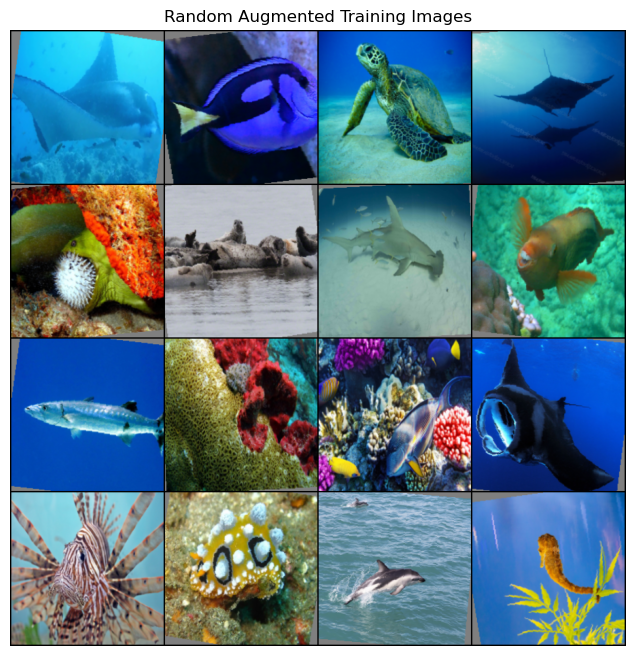

In [11]:
# plot some images

# Function to visualize a batch of images
def visualize_augmented_images(dataset, num_images=16):
    # Get 16 random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Load and transform the images
    images = []
    for idx in random_indices:
        image, _ = dataset[idx]
        images.append(image)
    
    # Stack images into a tensor
    images = torch.stack(images)

    # Denormalize images (assuming they're in [-1, 1] range)
    images = (images + 1) / 2

    # Create a grid of images
    grid = make_grid(images, nrow=4, padding=2)
    
    # Display the grid of images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title("Random Augmented Training Images")
    plt.show()

# Visualize 16 augmented images
visualize_augmented_images(train_dataset.dataset, num_images=16)

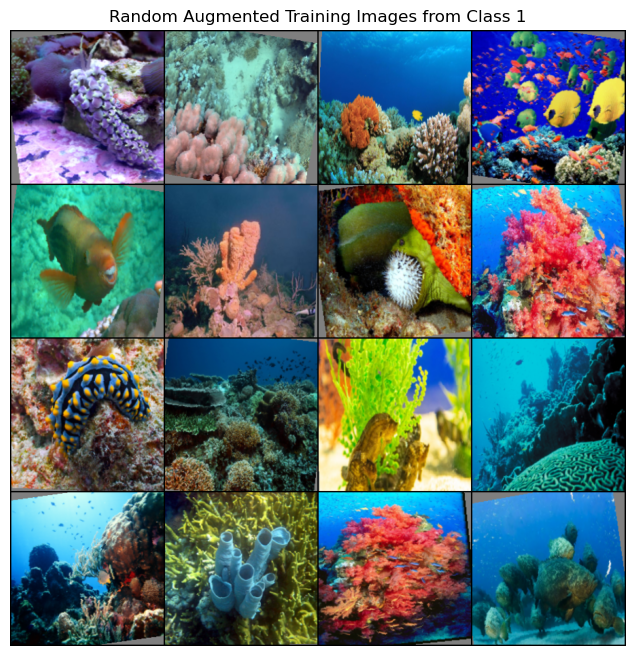

In [12]:
# Function to visualize augmented images from a particular class
def visualize_augmented_images_from_class(dataset, class_idx, num_images=16):
    # Get all the indices of the images that belong to the specified class
    class_indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
    
    # Randomly select 16 images from the class
    selected_indices = np.random.choice(class_indices, min(num_images, len(class_indices)), replace=False)
    
    # Load and transform the images
    images = []
    for idx in selected_indices:
        image, _ = dataset[idx]
        images.append(image)
    
    # Stack images into a tensor
    images = torch.stack(images)

    # Denormalize images (assuming they're in [-1, 1] range)
    images = (images + 1) / 2

    # Create a grid of images
    grid = make_grid(images, nrow=4, padding=2)
    
    # Display the grid of images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(f"Random Augmented Training Images from Class {class_idx}")
    plt.show()

# Visualize 16 augmented images from class 0 (you can change the class index as needed)
visualize_augmented_images_from_class(train_dataset.dataset, class_idx=1, num_images=16)

## Data loaders

In [13]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Load model

In [14]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(full_dataset.classes))
model = model.cuda()

/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
best_val_loss = float('inf')
patience = 10
counter = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epoch = 30

In [17]:
best_val_loss

inf

## Training loop with early stopping and model saving

In [18]:
start = time.time()

for epoch in range(num_epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early stopping & save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../models/best_model_basic.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# time taken
end = time.time()
diff = end - start
print(f"Time taken: {diff}")

Epoch 1: Train Loss=0.8728, Val Loss=0.3369, Train Acc=0.7249, Val Acc=0.9014
Epoch 2: Train Loss=0.4012, Val Loss=0.2149, Train Acc=0.8724, Val Acc=0.9151
Epoch 3: Train Loss=0.2799, Val Loss=0.1233, Train Acc=0.9085, Val Acc=0.9551
Epoch 4: Train Loss=0.2235, Val Loss=0.1327, Train Acc=0.9302, Val Acc=0.9613
Epoch 5: Train Loss=0.2208, Val Loss=0.0371, Train Acc=0.9339, Val Acc=0.9913
Epoch 6: Train Loss=0.1479, Val Loss=0.1103, Train Acc=0.9548, Val Acc=0.9538
Epoch 7: Train Loss=0.1444, Val Loss=0.0181, Train Acc=0.9529, Val Acc=0.9950
Epoch 8: Train Loss=0.1777, Val Loss=0.1651, Train Acc=0.9427, Val Acc=0.9613
Epoch 9: Train Loss=0.1167, Val Loss=0.1564, Train Acc=0.9649, Val Acc=0.9426
Epoch 10: Train Loss=0.2193, Val Loss=0.0612, Train Acc=0.9299, Val Acc=0.9763
Epoch 11: Train Loss=0.0925, Val Loss=0.0626, Train Acc=0.9711, Val Acc=0.9763
Epoch 12: Train Loss=0.1097, Val Loss=0.0408, Train Acc=0.9671, Val Acc=0.9875
Epoch 13: Train Loss=0.1086, Val Loss=0.0344, Train Acc=0.967

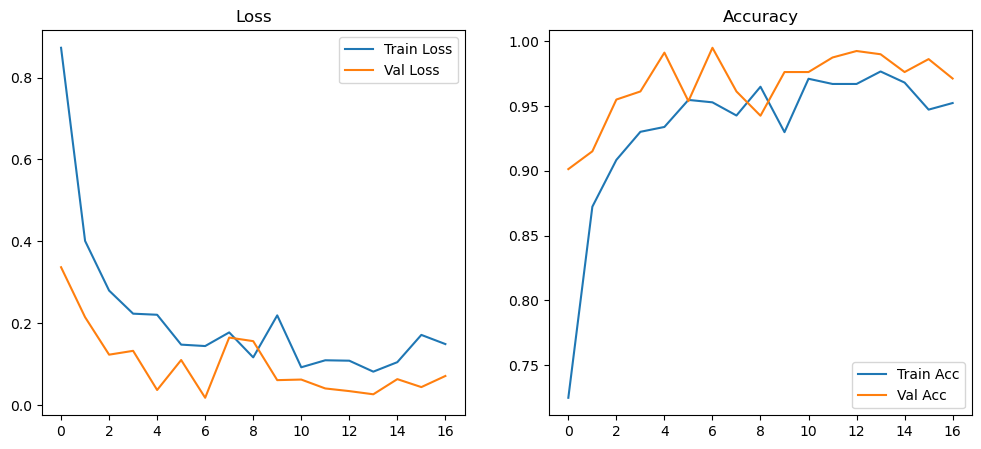

In [19]:
# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

## Load the best model

In [20]:
model.load_state_dict(torch.load("../models/best_model_basic.pt"))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Evaluate on test set

In [21]:
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.9913


## Confusion matrix

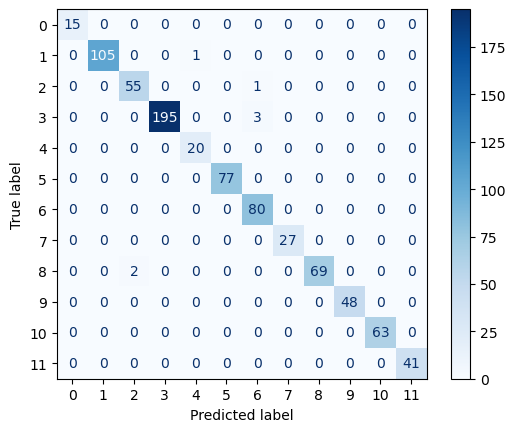

In [22]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()